In [1]:
from pandas import DataFrame
import pandas as pd
from numpy import trapz

class ROC():
    #EXERCISE A
    #constructor of the class that initializes the self instances:
    #Probs : Probabilities of class probabilities of P positive and N negative test instances
    #TrueClass : true class labels of the test instances
    def __init__(self,Probs,TrueClass):
        self.Probs = Probs
        self.TrueClass = TrueClass
        
    #EXERCISE B
    #method that returns the roc curve coordinates
    def compute_ROC_coordinates(self):
        #get the nbr of positive and negative test instances
        P,N = self.get_PN_of_TrueClass()
        #order the probs and true class in decreasing order dependig on the Probs with the same index
        self.order()
        FP = 0
        TP = 0
        #initialize the dataframe that will contain the coordinates
        ROC_coordinates = pd.DataFrame(columns = ['TPr','FPr'])
        Previous_Prob = -float('inf')
        for i in range(len(self.Probs)):
            #if the new threshold is different than the last one, then we add the TPr and FPr coordinates
            if self.Probs.iloc[i]!=Previous_Prob:
                ROC_coordinates.loc[len(ROC_coordinates)] = (FP/N,TP/P)
                Previous_Prob = self.Probs.iloc[i]
            #there is a threshold at the instance if its true class changes than the previous one
            #if there is a change, then if it becomes positive, we increase the nbr of true positive instances 
            #and the nbr of false positive instances otherwise
            if self.TrueClass.iloc[i]==1:
                TP = TP+1
            else:
                FP = FP+1
        #add the (1,1) coordinate (should be = 1,1 if we computed each instances correclty)
        ROC_coordinates.loc[len(ROC_coordinates)] = (FP/N,TP/P)
        return ROC_coordinates
        
    #method that gets the nbr of positive and negative test instances
    def get_PN_of_TrueClass(self):
        P = 0
        N = 0
        for i in range(len(self.TrueClass)):
            #we check for each instances, if it is positive then = 1 and = 0 otherwise
            if self.TrueClass.iloc[i].item()==1:
                P = P+1
            else:
                N = N+1
        return P,N
    
    #method that orders the probs and true class in decreasing order dependig on the Probs with the same index
    def order(self):
        #first join the 2 dataframe together
        temp = self.Probs.join(self.TrueClass)
        #then reindex the two dataframe depending on the posterior positive probability
        self.Probs = temp.sort_values('Probs', ascending = False)['Probs']
        self.TrueClass = temp.sort_values('Probs', ascending = False)['TrueClass']
        

    #EXERCISE C  
    #method that plots the roc coordinates 
    def plot_ROC(self, roc_coordinates):
        plt.plot(roc_coordinates['FPr'], roc_coordinates['TPr'])
        plt.xlabel('False Positive')
        plt.ylabel('True Positive')
        
    #EXERCISE D
    #method that computes the area under the curve
    def compute_AUCROC(self, roc_coordinates): 
        return trapz(roc_coordinates['TPr'],roc_coordinates['FPr'])
        

        
        
        

# EXERCISE B
How do I handle test instances of opposite classes that have the same probability for the positive class ?

If p and n are the numbers of positive and negative test instances, respectively, with the same posterior probability for the positive class, then we  update TP equal to TP + p and FP equal to FP + n. Once the updates have been completed, we add point (TP/P , FP/N)  to ROC_coordinates. This implies the ROC curve that we build is the average curve over all the ROC curves based on all possible orders of positive and negative test instances with the same posterior probability.

(Appendix A)

In [2]:
# Class of k-Nearest Neigbor Classifier used to create the classifier to be tested
import pandas as pd
from sklearn import preprocessing

class kNN():
    def __init__(self, k = 3, exp = 2):
    # constructor for kNN classifier 
    # k is the number of neighbor for local class estimation
    # exp is the exponent for the Minkowski distance
        self.k = k
        self.exp = exp
        
        
      
    def fit(self, X_train, Y_train):
    # training k-NN method
    # X_train is the training data given with input attributes. n-th row correponds to n-th instance.
    # Y_train is the output data (output vector): n-th element of Y_train is the output value for n-th instance in X_train.
        self.X_train = X_train
        self.Y_train = Y_train   

    
    def Minkowski_distance(self, x1, x2):
    # computes the Minkowski distance of x1 and x2 for two labeled instances (x1,y1) and (x2,y2)
    
        # Set initial distance to 0
        distance = 0
    
        # Calculate Minkowski distance using the exponent exp
        for i in range(len(x1)):
            distance = distance + abs(x1[i] - x2[i])**self.exp
        
        distance = distance**(1/self.exp)
    
        return distance
    
    #I created a static method that takes X_train and X_test as paremeters and returns the same values normalized the the max of X_train
    @staticmethod
    def normalize(X_train,X_test):
        max = X_train.max()
        X_train = X_train/max
        X_test = X_test/max
        return X_train, X_test

        
    def getClassProbs(self, X_test):
    # X_test is the test data given with input attributes. Rows correpond to instances
    # Method outputs posterior class probabilities of vector Y_pred_test:  n-th element of Y_pred_test is the set of class probas. for n-th instance in X_test
   
        #compute all possible class as columns (the row will represent each test instance and their probas)
        possibleClass = list(pd.unique(self.Y_train))
    
        #table that will contain each test instance as row with their probas. and colum as all possible class
        Y_postClassProba_test = pd.DataFrame(columns = possibleClass) 

        for i in range(len(X_test)):   #iterate over all instances in X_test
            test_instance = X_test.iloc[i] #i-th test instance 
            
            distances = []  #list of distances of the i-th test_instance for all the train_instance s in X_train, initially empty.
          
            for j in range(len(self.X_train)):  #iterate over all instances in X_train
                train_instance = self.X_train.iloc[j] #j-th training instance 
                distance = self.Minkowski_distance(test_instance, train_instance) #distance between i-th test instance and j-th training instance  
                distances.append(distance) #add the distance to the list of distances of the i-th test_instance
        
            # Store distances in a dataframe. The dataframe has the index of Y_train in order to keep the correspondence with the classes of the training instances 
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index = self.Y_train.index)
        
            # Sort distances, and only consider the k closest points in the new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]         

            # Note that the index df_knn.index of df_knn contains indices in Y_train of the k-closed training instances to 
            # the i-th test instance. Thus, the dataframe self.Y_train[df_knn.index] contains the classes of those k-closed 
            # training instances. Method value_counts() computes the counts (number of occurencies) for each class in 
            # self.Y_train[df_knn.index] in dataframe predictions. 
            predictions = self.Y_train[df_knn.index].value_counts()
            
            #all points around the test instance that are in the k-range
            innerPoints = self.Y_train[df_knn.index]
            #take the nbr of points in that k-range to calculate later the probas.
            totalNbrOfInstances = len(innerPoints)
            
            probs = []
            #calculate for all possible class, the probas. of each test instance 
            for j in range(len(possibleClass)):
                #if the occurence of the class is different than 0
                try:
                    probs.append((predictions.iloc[j]/totalNbrOfInstances).item())
                #if the occurence is equal to 0, its proba is also 0
                except:
                    probs.append(0)

                                    
            # add the probas. of y_pred_test for all the test instances in X_test
            Y_postClassProba_test.loc[i] = probs
            #delete the column negative since we only need the positive one to know the two of them and to compute the ROC curve coordinates
        del Y_postClassProba_test['tested_negative']
        return Y_postClassProba_test       


         TPr       FPr
0   0.000000  0.000000
1   0.005952  0.000000
2   0.029762  0.000000
3   0.053571  0.000000
4   0.077381  0.010638
5   0.095238  0.010638
6   0.136905  0.010638
7   0.166667  0.021277
8   0.178571  0.021277
9   0.214286  0.021277
10  0.238095  0.021277
11  0.273810  0.021277
12  0.297619  0.021277
13  0.345238  0.021277
14  0.369048  0.042553
15  0.398810  0.085106
16  0.452381  0.095745
17  0.470238  0.106383
18  0.500000  0.138298
19  0.517857  0.159574
20  0.553571  0.159574
21  0.577381  0.180851
22  0.613095  0.180851
23  0.636905  0.191489
24  0.666667  0.265957
25  0.672619  0.287234
26  0.690476  0.287234
27  0.702381  0.319149
28  0.702381  0.329787
29  0.702381  0.340426
30  0.714286  0.361702
31  0.732143  0.361702
32  0.755952  0.382979
33  0.761905  0.393617
34  0.779762  0.414894
35  0.791667  0.457447
36  0.809524  0.489362
37  0.815476  0.500000
38  0.827381  0.531915
39  0.845238  0.563830
40  0.851190  0.617021
41  0.875000  0.638298
42  0.88690

0.7611765450861195

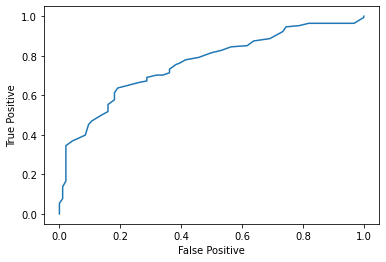

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy.random import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

##################################################
# Hold-out testing: Training and Test set creation
##################################################

data = pd.read_csv('diabetes.csv')
Y = data['class']
X = data.drop(['class'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

#normalize the data to have better results
X_train, X_test = kNN.normalize(X_train,X_test)

#I chose to calculates the probas. with a k=10
k = 100
clf = kNN(k)
clf.fit(X_train, Y_train)

#preparing the data (posterior class positive probability and the true class)
y_pred_probs = clf.getClassProbs(X_test)
for i in range(len(Y_test)):
    if(Y_test.iloc[i]=='tested_positive'):
        Y_test.iloc[i]=1
    else:
        Y_test.iloc[i]=0
y_pred_probs.columns= ['Probs']
Y_true = {'TrueClass': Y_test}
Y_true = pd.DataFrame(Y_true)
y_pred_probs.index = (Y_true.index)

#new object of the ROC class
roc = ROC(y_pred_probs,Y_true)
#compute the roc coordinates
roc_coordinates = roc.compute_ROC_coordinates()
print(roc_coordinates)
#plot those
roc.plot_ROC(roc_coordinates)
#compute the area under the curve
roc.compute_AUCROC(roc_coordinates)